In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats
import numpy as np
import cv2
import pickle
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("device in use: ", device)

device in use:  cuda


## 1. Zielstellung: Entwicklung eines neuronalen Netzwerkmodells zur Diagnose von Lungenentzündungen.
In der heutigen medizinischen Diagnostik spielen bildgebende Verfahren eine entscheidende Rolle, insbesondere bei der Erkennung und Behandlung von Lungenentzündungen. Trotz des Fortschritts in der medizinischen Bildgebung bleibt die präzise Diagnose von Lungenentzündungen durch herkömmliche Methoden eine Herausforderung, die häufig umfangreiche Fachkenntnisse und Erfahrungen erfordert. Dies kann besonders in Regionen mit begrenztem Zugang zu qualifizierten Radiologen problematisch sein.

Das Ziel ist es, diese Herausforderung durch die Entwicklung eines neuronalen Netzwerkmodells anzugehen, das automatisch Lungenentzündungen anhand von Brust-Röntgenbildern diagnostizieren kann. Durch den Einsatz maschinellen Lernens (in diesem Fall Deep Learning) streben wir danach, die Genauigkeit der Diagnosen zu verbessern, die Bearbeitungszeit zu verkürzen und letztendlich die Belastung für das medizinische Personal zu reduzieren.

## 2. Datensatz
Das Dataset enthält 5.863 Röntgenbilder (JPEG) in zwei Kategorien (Pneumonie/Normal), aufgeteilt in drei Ordner (Train, Test, Val). Die Bilder stammen von pädiatrischen Patienten des Guangzhou Women and Children’s Medical Center und wurden nach Qualitätssicherung und Bewertung durch Experten für das Training eines KI-Systems verwendet.
(sehe: https://data.mendeley.com/datasets/rscbjbr9sj/2)

## 3. Analyse und Visualisierung von Zusammenhängen
Vor Beginn des Trainings ist die Voranalyse des Datensatzes und die Überprüfung der Korrelationen ein wichtiger Schritt, insbesondere beim Umgang mit großen und komplexen Datensätzen. Bei Bilddaten umfasst diese Analyse typischerweise die Untersuchung der Verteilung der Bilder, der Klassenbalance, der Bildgröße und -qualität usw.

### 3.1. Bilderverteilung und Klassenbalance

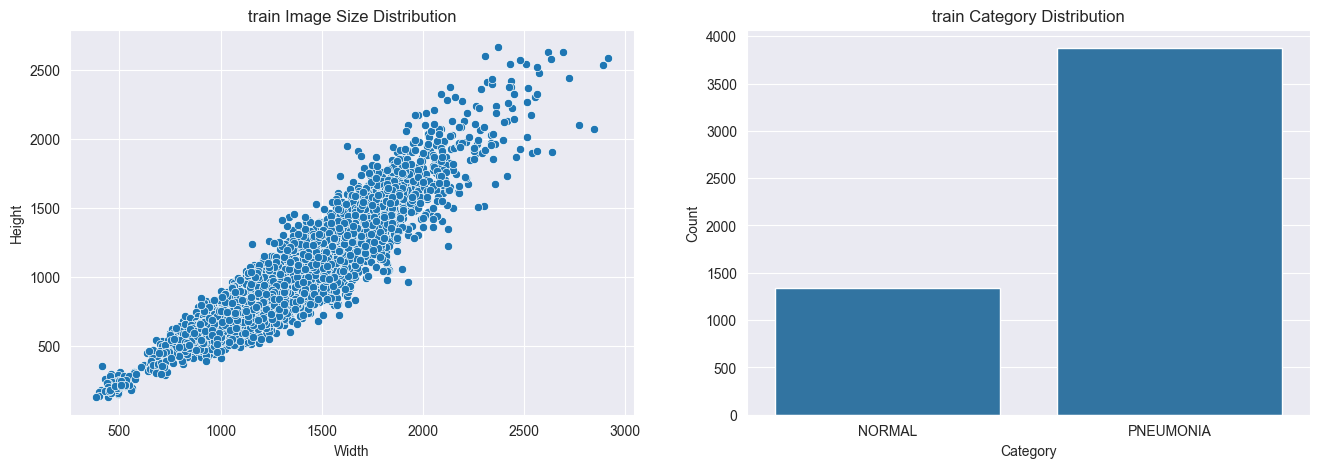

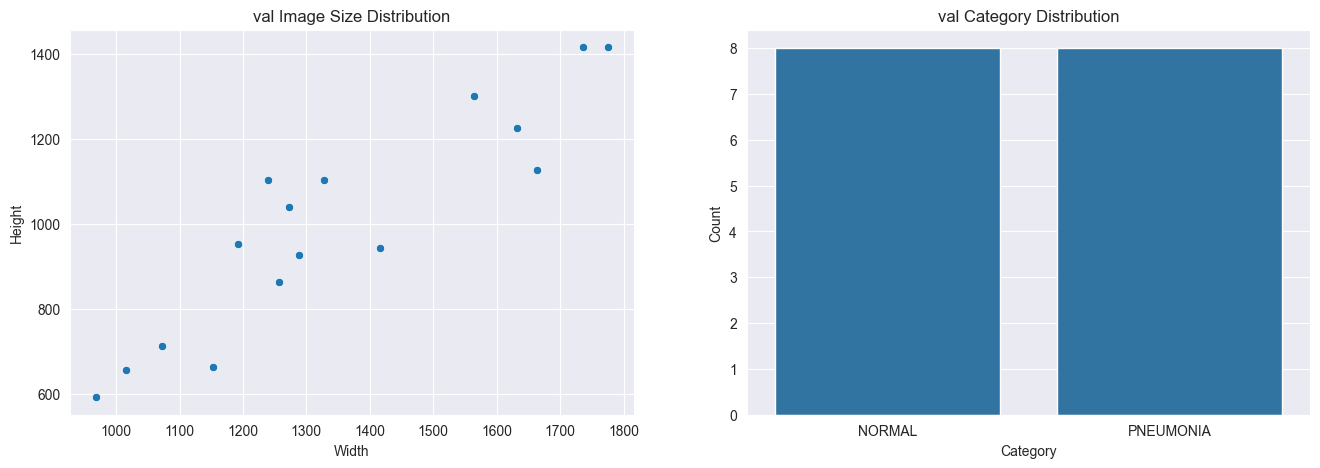

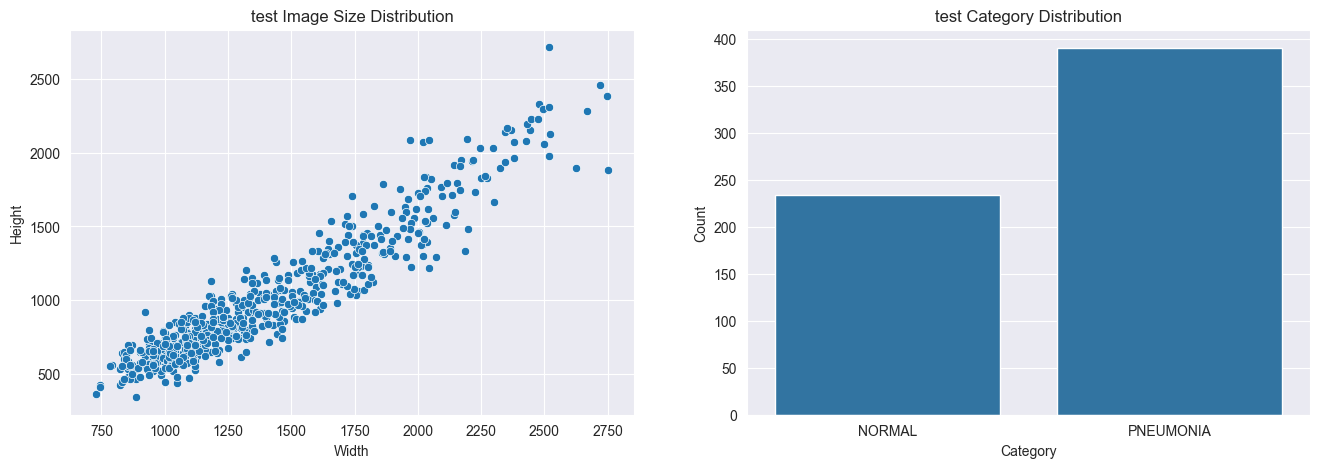

In [2]:
# Überprüfen die Größe- und Kategorieverteilung der Bilder
def analyze_dataset(folder_path):
    sizes = []
    categories = []

    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            with Image.open(image_path) as img:
                sizes.append(img.size)
                categories.append(category)

    return sizes, categories


def show_size_category_distribution(subset, sizes, categories):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    widths, heights = zip(*sizes)
    sns.scatterplot(x=widths, y=heights, ax=axes[0])
    axes[0].set_xlabel('Width')
    axes[0].set_ylabel('Height')
    axes[0].set_title(subset + ' Image Size Distribution')

    category_counts = Counter(categories)
    sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), ax=axes[1])
    axes[1].set_xlabel('Category')
    axes[1].set_ylabel('Count')
    axes[1].set_title(subset + ' Category Distribution')

    plt.show()


train, val, test = 'train', 'val', 'test'

folder_paths = [train, val, test]
sizes_dic = {}
categories_dic = {}
for folder_path in folder_paths:
    sizes, categories = analyze_dataset(folder_path)
    show_size_category_distribution(folder_path, sizes, categories)
    sizes_dic[folder_path] = sizes
    categories_dic[folder_path] = categories

In [3]:
print(sizes_dic[train][:10])

[(2090, 1858), (1422, 1152), (1810, 1434), (1618, 1279), (1600, 1125), (1974, 1306), (1528, 1013), (1384, 1167), (1450, 1144), (1468, 993)]


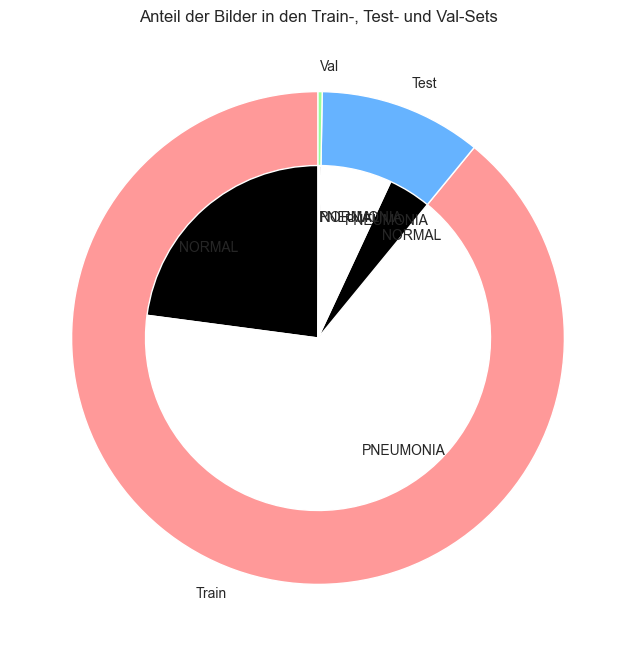

In [4]:
# Zählen der Kategorien in jedem Subset
def show_pie_chart(categories_dic):
    train_counts = Counter(categories_dic[train])
    test_counts = Counter(categories_dic[test])
    val_counts = Counter(categories_dic[val])

    # Berechnung der Gesamtanzahl in jedem Subset
    train_total = sum(train_counts.values())
    test_total = sum(test_counts.values())
    val_total = sum(val_counts.values())

    # Berechnung der Gesamtanzahl im gesamten Datensatz
    total = train_total + test_total + val_total

    # Definition der Farben
    outer_colors = ['#ff9999', '#66b3ff', '#99ff99']
    inner_colors = ['#000000', '#ffffff']

    # Berechnung des Anteils jeder Kategorie in jedem Subset
    train_sizes = [count / total for count in train_counts.values()]
    test_sizes = [count / total for count in test_counts.values()]
    val_sizes = [count / total for count in val_counts.values()]

    # Festlegung des Startpunkts für jedes Subset
    train_start = 0
    test_start = train_start + sum(train_sizes)
    val_start = test_start + sum(test_sizes)

    # Erstellen eines Kuchendiagramms
    plt.figure(figsize=(8, 8))
    wedges, texts = plt.pie([train_total, test_total, val_total],
                            labels=['Train', 'Test', 'Val'],
                            startangle=90,
                            colors=outer_colors,
                            radius=1)

    # Erstellen von Kuchendiagrammen innerhalb jedes Subsets, um das Verhältnis von NORMAL und PNEUMONIA darzustellen
    plt.pie([*train_counts.values(), *test_counts.values(), *val_counts.values()],
            radius=0.7,
            startangle=90,
            colors=inner_colors,
            labels=[*train_counts.keys(), *test_counts.keys(), *val_counts.keys()],
            labeldistance=0.7)

    plt.title("Anteil der Bilder in den Train-, Test- und Val-Sets")
    plt.show()


show_pie_chart(categories_dic)

### 3.2. Überprüfen Format und Modus von Bildern

In [5]:
def count_image_formats_and_modes(folder_path):
    formats = set()
    modes = set()

    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            try:
                with Image.open(image_path) as img:
                    formats.add(img.format)
                    modes.add(img.mode)
            except IOError:
                print(f"Cannot open {image_name}")

    return formats, modes


for folder_path in folder_paths:
    formats, modes = count_image_formats_and_modes(folder_path)
    print(f"Subset: {folder_path}, Formats: {formats}, Modes: {modes}")
# Die Ergebnisse zeigen, dass das Format der Bilder ausschließlich JPEG ist und keine Anpassung erforderlich ist. Es gibt jedoch zwei Bildmodi: Graustufenbilder und RGB-Farbbilder. Wir müssen diese RGB-Bilder in Graustufenbilder konvertieren.

Subset: train, Formats: {'JPEG'}, Modes: {'RGB', 'L'}
Subset: val, Formats: {'JPEG'}, Modes: {'L'}
Subset: test, Formats: {'JPEG'}, Modes: {'L'}


### 3.x. Medizinische Bildanalyse
Normales Röntgenbild: Klare Lungenfelder ohne Schatten, deutlich sichtbare Lungentextur, dunkle Alveolen.

Röntgenbild bei Lungenentzündung: Schatten oder verschwommene Bereiche in den Lungen, verdichtete Lungentextur, Alveolen erscheinen aufgrund von Entzündungen weißlicher oder undurchsichtiger.

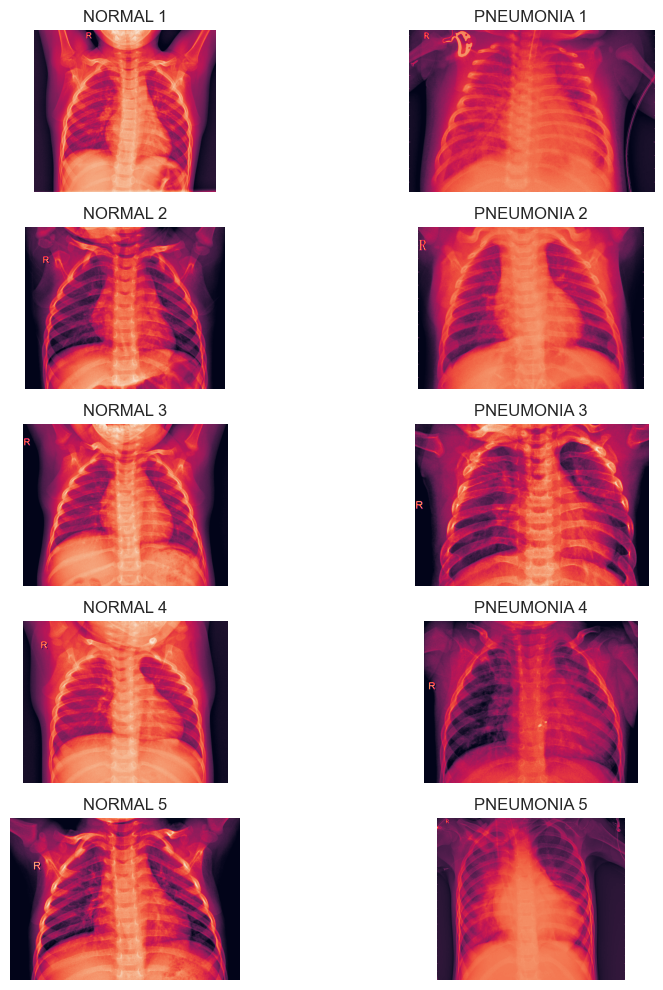

In [6]:
def display_sample_images_side_by_side(folder_path, categories, num_samples=5):
    fig, axes = plt.subplots(num_samples, len(categories), figsize=(10, 10))

    for i, category in enumerate(categories):
        category_path = os.path.join(folder_path, category)
        sample_images = os.listdir(category_path)[:num_samples]
        for j, image_name in enumerate(sample_images):
            img_path = os.path.join(category_path, image_name)
            img = Image.open(img_path)
            axes[j, i].imshow(img)
            axes[j, i].axis('off')
            axes[j, i].set_title(f"{category} {j + 1}")

    plt.tight_layout()
    plt.show()

categories = ['NORMAL', 'PNEUMONIA']
display_sample_images_side_by_side(train, categories)
# Basierend auf diesen Beispielbildern scheint es, dass das menschliche Auge allein keinen großen Unterschied erkennen kann.

## 4. Bereinigen, Extrahieren und Transformieren von Daten

### 4.1. Entfernen von Ausreißern bezüglich der Bildgröße
Zunächst wird eine lineare Regressionsanalyse für zwei Variablen (in diesem Fall Breite und Höhe) durchgeführt, um eine gerade Linie mit der besten Anpassung (Regressionslinie) zu berechnen. Als Nächstes wird der senkrechte Abstand jedes Datenpunkts von dieser Linie berechnet. Dann wird ein Schwellenwert basierend auf der Standardabweichung und dem Mittelwert dieser Abstände festgelegt. Beispielsweise werden Datenpunkte, deren Abstand den Mittelwert plus das Zweifache der Standardabweichung überschreitet, als Ausreißer betrachtet. Schließlich werden Datenpunkte, deren Abstand kleiner als dieser Schwellenwert ist, als Nicht-Ausreißer ausgewählt.

In [7]:
def remove_size_outliers(img_paths, sizes):
    widths, heights = zip(*sizes)
    slope, intercept, _, _, _ = stats.linregress(widths, heights)

    # Berechnung des Abstands jedes Punktes zur Regressionslinie
    distances = [abs(height - (slope * width + intercept)) for width, height in zip(widths, heights)]
    std_dev = np.std(distances)
    mean_distance = np.mean(distances)

    # Festlegen eines Schwellenwerts, zum Beispiel das 2-fache der Standardabweichung
    threshold = mean_distance + 2 * std_dev
    
    # Auswahl von Bildern, deren Abstand unter dem Schwellenwert liegt
    normal_images = [file for file, distance in zip(img_paths, distances) if distance < threshold]

    return normal_images

### 4.2. Um eine k-fache Kreuzvalidierung zu erreichen, unterscheiden wir nicht mehr zwischen Tranieren-, Validierungs- und Testdaten, sondern führen sie zuerst zusammen.

In [8]:
import os
from KIundBigData_util import CustomDataset

def create_image_dataset(root_dir):
    subsets = ['train', 'val', 'test']
    categories = ['NORMAL', 'PNEUMONIA']
    all_images = []
    all_labels = []

    # Sammeln aller Bildpfade und Etiketten
    for subset in subsets:
        for label, category in enumerate(categories):
            category_dir = os.path.join(root_dir, subset, category)
            for img in os.listdir(category_dir):
                all_images.append(os.path.join(category_dir, img))
                all_labels.append(label)

    # Ermitteln aller Bildgrößen
    image_sizes = []
    for path in all_images:
        with Image.open(path) as img:
            image_sizes.append(img.size)

    print('vorher: ', len(image_sizes))
    # Verwenden der remove_size_outliers Methode, um Bilder mit abnormalen Größen zu entfernen
    normal_images = remove_size_outliers(all_images, image_sizes)
    print('nachher: ', len(normal_images))
    
    # Filtern und Entfernen von Bildern mit abnormalen Größen
    images = [img for img in all_images if img in normal_images]
    labels = [label for img, label in zip(all_images, all_labels) if img in normal_images]

    return images, labels

images, labels = create_image_dataset('')
print(images[:10])
print(labels[:10])

vorher:  5856
nachher:  5590
['train\\NORMAL\\IM-0115-0001.jpeg', 'train\\NORMAL\\IM-0117-0001.jpeg', 'train\\NORMAL\\IM-0119-0001.jpeg', 'train\\NORMAL\\IM-0122-0001.jpeg', 'train\\NORMAL\\IM-0125-0001.jpeg', 'train\\NORMAL\\IM-0128-0001.jpeg', 'train\\NORMAL\\IM-0129-0001.jpeg', 'train\\NORMAL\\IM-0131-0001.jpeg', 'train\\NORMAL\\IM-0133-0001.jpeg', 'train\\NORMAL\\IM-0135-0001.jpeg']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 4.3. Kontrast verstärken
Wenn das Röntgenbild einen geringen Kontrast aufweist und es an klaren Details mangelt, kann die Verstärkung des Kontrasts dazu beitragen, die Textur und Merkmale der Lunge hervorzuheben und so abnormale Bereiche (z. B. Entzündungen oder Infektionen) leichter zu identifizieren.

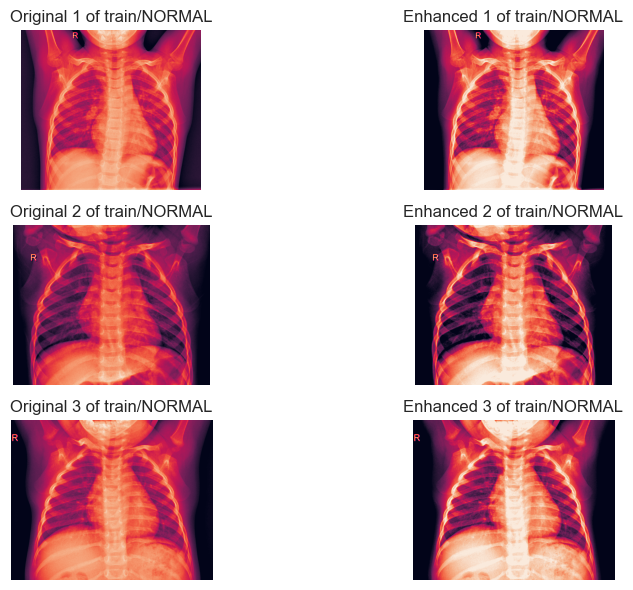

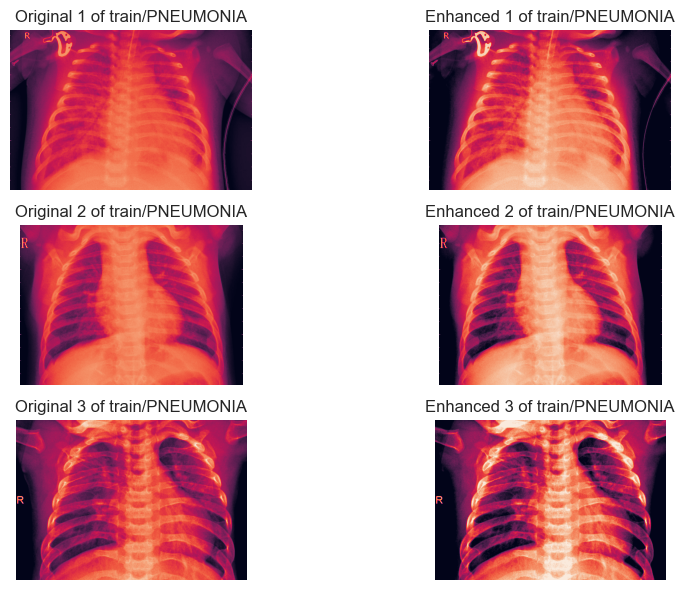

In [9]:
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageEnhance


def enhance_contrast(image, enhancement_factor=1.5):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(enhancement_factor)


def display_contrast_enhancement(folder_path, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    sample_images = os.listdir(folder_path)[:num_samples]
    for i, image_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, image_name)
        img = Image.open(img_path)

        # Das originale Bild
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Original {i + 1} of {folder_path}")

        # Bild nach Kontrastverstärkung
        enhanced_img = enhance_contrast(img)
        axes[i, 1].imshow(enhanced_img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Enhanced {i + 1} of {folder_path}")

    plt.tight_layout()
    plt.show()


display_contrast_enhancement(train + '/NORMAL')
display_contrast_enhancement(train + '/PNEUMONIA')

### 4.4. Rauschreduzierung mit Gaußscher Filterung
Die Gaußsche Filterung ist eine auf der Gaußschen Verteilung basierende Glättungstechnologie, mit der Bildrauschen wirksam reduziert werden kann, insbesondere bei der Beibehaltung von Kanten.

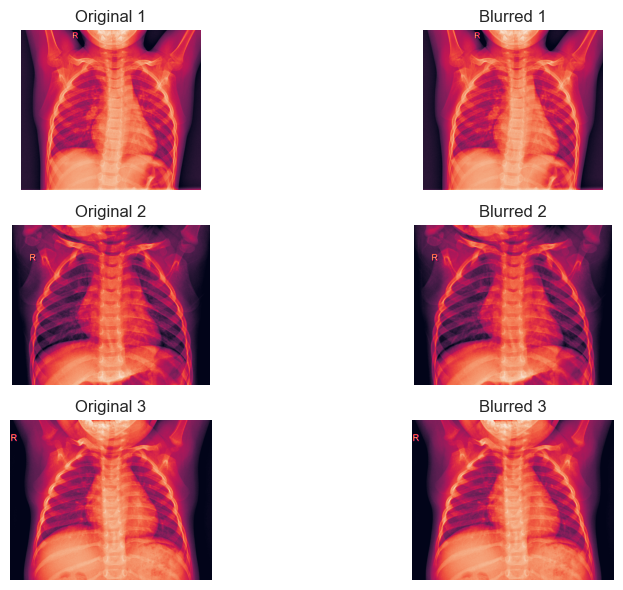

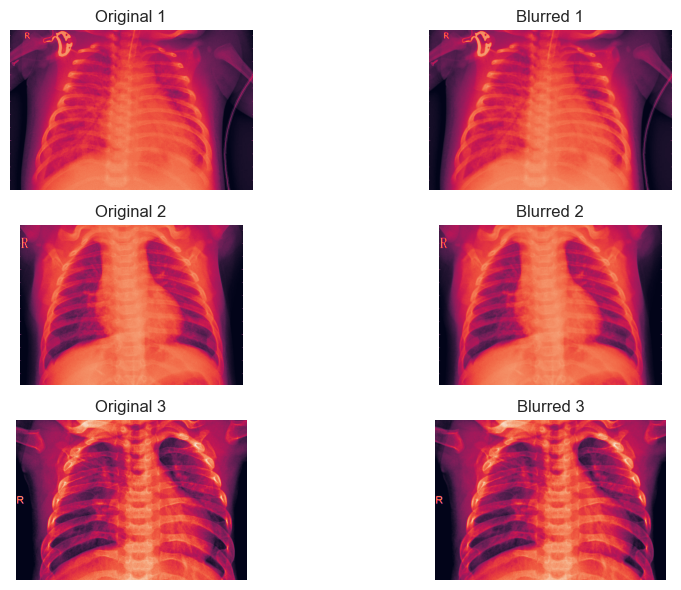

In [10]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from PIL import Image


def apply_gaussian_blur(image, blur_amount=(5, 5)):
    image_np = np.array(image)
    blurred_image_np = cv2.GaussianBlur(image_np, blur_amount, 0)
    return Image.fromarray(blurred_image_np)


def display_gaussian_blur_effect(folder_path, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    sample_images = os.listdir(folder_path)[:num_samples]
    for i, image_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, image_name)
        img = Image.open(img_path)

        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Original {i + 1}")

        blurred_img = apply_gaussian_blur(img)
        axes[i, 1].imshow(blurred_img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Blurred {i + 1}")

    plt.tight_layout()
    plt.show()

display_gaussian_blur_effect(train + '/NORMAL', num_samples=3)
display_gaussian_blur_effect(train + '/PNEUMONIA', num_samples=3)

## 5. Wählen ein passendes ML-Modell und werten die Performance in einer Kreuzvalidierung aus.

### 5.1. Daten verarbeiten
Um eine k-fache Kreuzvalidierung zu erreichen, heben wir die Unterscheidung zwischen train, val und test auf und behalten stattdessen nur die beiden Kategorien NORMAL und PNEUMONIA bei.

In [68]:
from torchvision import transforms
from KIundBigData_util import EnhanceContrast, GaussianBlur

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    EnhanceContrast(),
    GaussianBlur(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = CustomDataset(images, labels, transform=transform)

In [69]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset, Subset

def create_dataloaders_and_check_ratios(dataset, k=5, batch_size=32):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
 
    dataloaders_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(dataset)), dataset.labels)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_labels = [dataset.labels[i] for i in train_idx]
        val_labels = [dataset.labels[i] for i in val_idx]
        print(f"Fold {fold + 1}:")
        print(f"  Training set: Class 0 = {train_labels.count(0)}, Class 1 = {train_labels.count(1)}")
        print(f"  Validation set: Class 0 = {val_labels.count(0)}, Class 1 = {val_labels.count(1)}")

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

        dataloaders_list.append((train_loader, val_loader))

    return dataloaders_list

dataloaders_list = create_dataloaders_and_check_ratios(dataset, k=5, batch_size=32)

Fold 1:
  Training set: Class 0 = 1149, Class 1 = 3323
  Validation set: Class 0 = 288, Class 1 = 830
Fold 2:
  Training set: Class 0 = 1149, Class 1 = 3323
  Validation set: Class 0 = 288, Class 1 = 830
Fold 3:
  Training set: Class 0 = 1150, Class 1 = 3322
  Validation set: Class 0 = 287, Class 1 = 831
Fold 4:
  Training set: Class 0 = 1150, Class 1 = 3322
  Validation set: Class 0 = 287, Class 1 = 831
Fold 5:
  Training set: Class 0 = 1150, Class 1 = 3322
  Validation set: Class 0 = 287, Class 1 = 831


### 5.2. Definieren ein CNN Modell und trainieren es

In [166]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from IPython.display import clear_output

loss_file_path = 'KIundBigData_loss_curve.pkl'
def train_model(device, dataloaders_list, num_epochs):
    fold_results = []

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    fold_roc_aucs = []

    for fold, (train_loader, val_loader) in enumerate(dataloaders_list, 1):
        print(f"Fold {fold}/{len(dataloaders_list)}")

        # Reset model and optimizer in each fold
        model = SimpleCNN(num_classes=2)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        dataloaders = {'train': train_loader, 'val': val_loader}

        fold_train_losses, fold_val_losses = [], []

        # Training and validation loop
        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        if phase == 'val':
                            # Merke nur die preds und trues in letzter Epoche
                            if epoch == num_epochs - 1:
                                fold_accuracies.append(accuracy_score(labels.cpu().numpy(), preds.cpu().numpy()))
                                fold_precisions.append(
                                    precision_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0))
                                fold_recalls.append(
                                    recall_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0))
                                fold_f1s.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0))
                                try:
                                    fold_roc_aucs.append(roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy()))
                                except ValueError:
                                    fold_roc_aucs.append(float('inf'))

                    running_loss += loss.item() * inputs.size(0)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)

                if phase == 'train':
                    fold_train_losses.append(epoch_loss)
                else:
                    fold_val_losses.append(epoch_loss)

            # Plotting
            clear_output(wait=True)
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(fold_train_losses, label='Train Loss')
            plt.plot(fold_val_losses, label='Val Loss')
            plt.title(f'Fold {fold} - Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        fold_results.append((fold_train_losses, fold_val_losses))

    # Save results
    with open(loss_file_path, 'wb') as f:
        pickle.dump(fold_results, f)

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s, fold_roc_aucs

In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

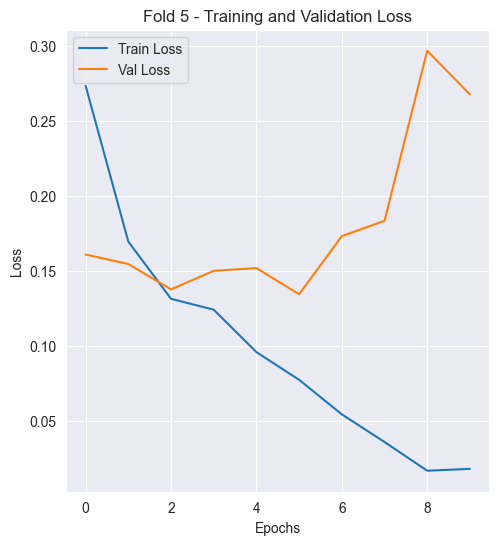

Duration：21.855207514762878 min(s)


In [168]:
import time

start_time = time.time()
fold_accuracies, fold_precisions, fold_recalls, fold_f1s, fold_roc_aucs = train_model(device, dataloaders_list, num_epochs=10)
end_time = time.time()
print(f"Duration：{(end_time - start_time) / 60} min(s)")

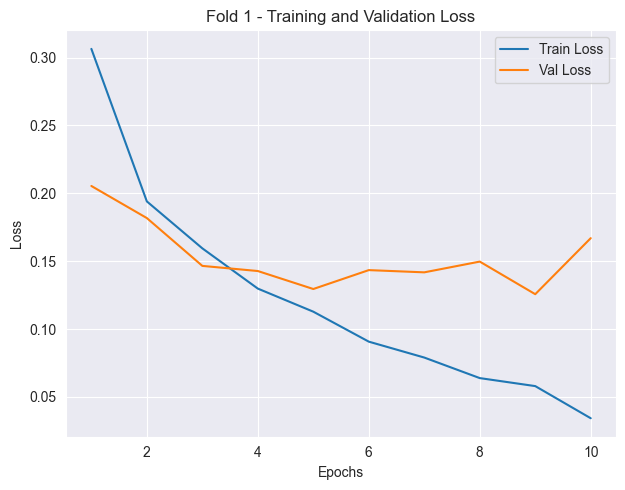

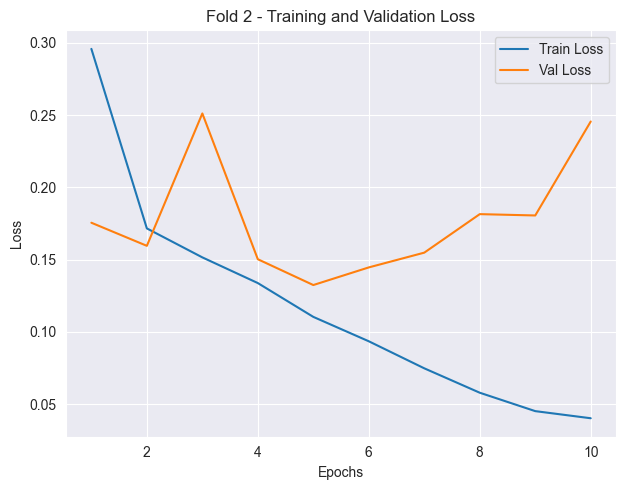

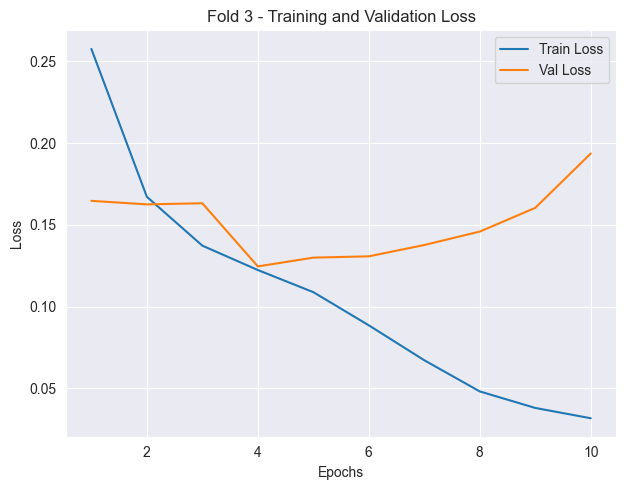

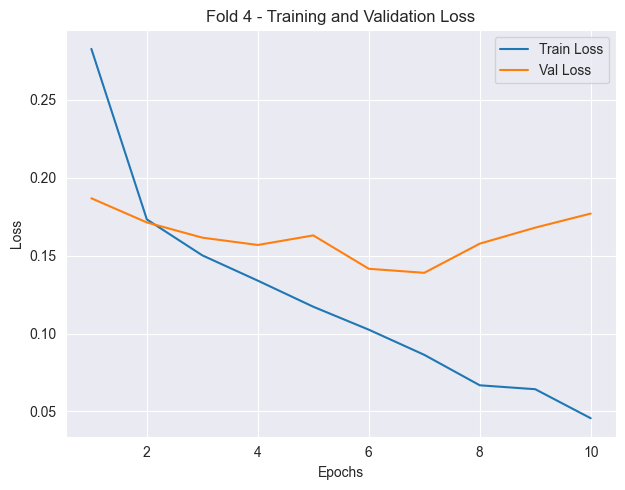

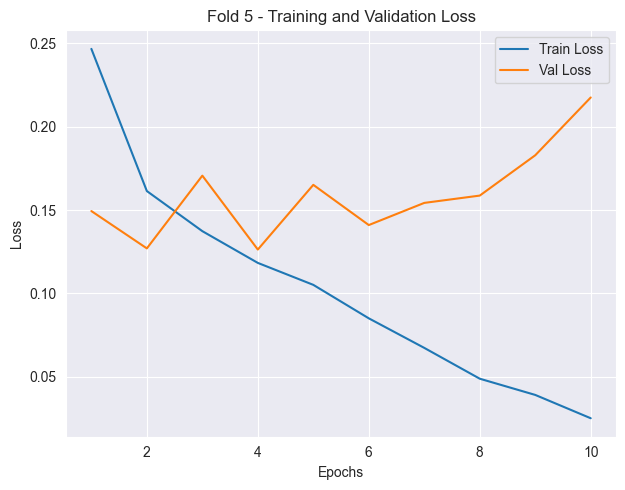

In [177]:
import pickle
import matplotlib.pyplot as plt

# with open('KIundBigData_loss_curve.pkl', 'rb') as f:
with open('KIundBigData_loss_curve2.pkl', 'rb') as f:
    fold_results = pickle.load(f)

for i, (train_losses, val_losses) in enumerate(fold_results, start=1):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'Fold {i} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

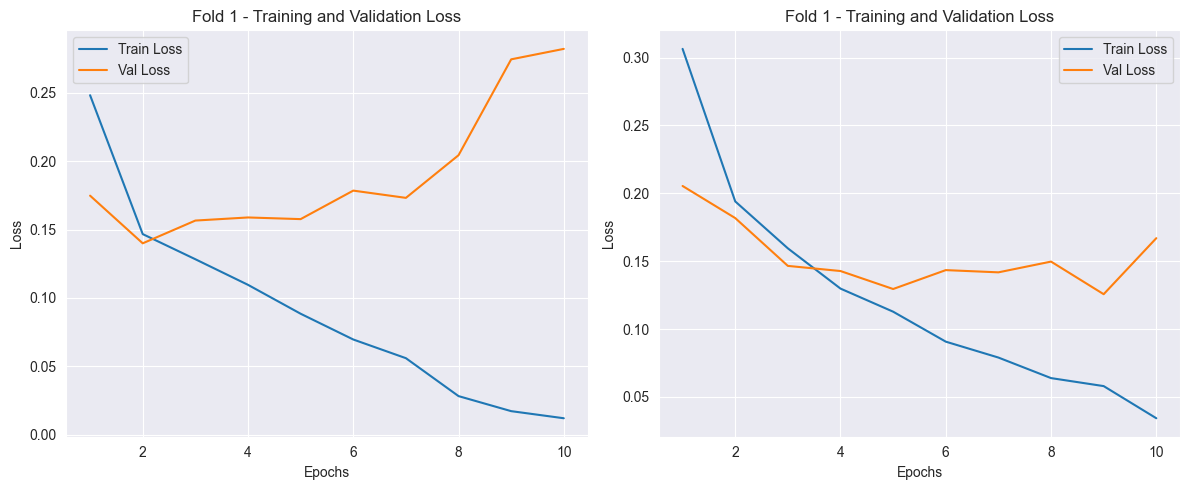

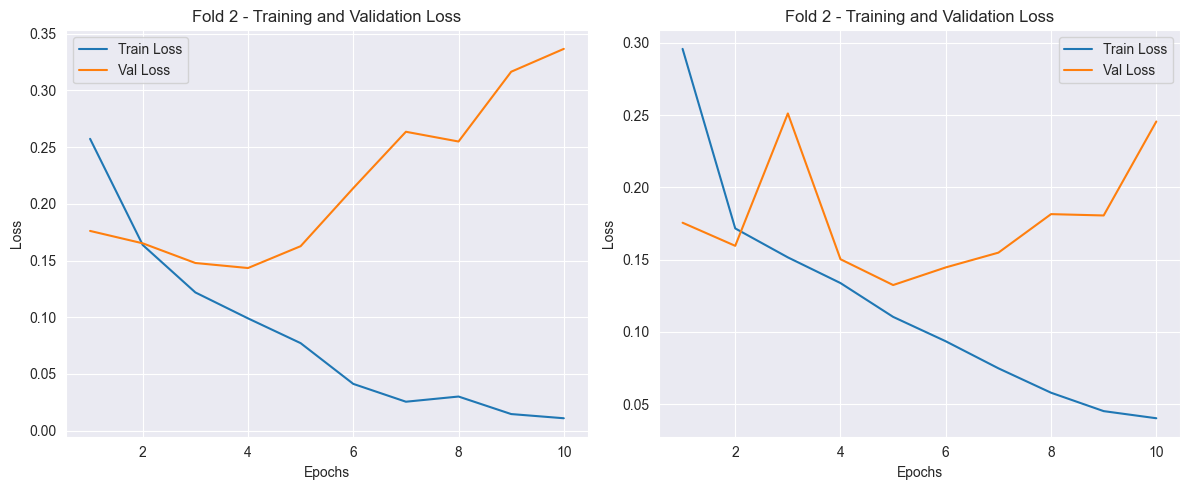

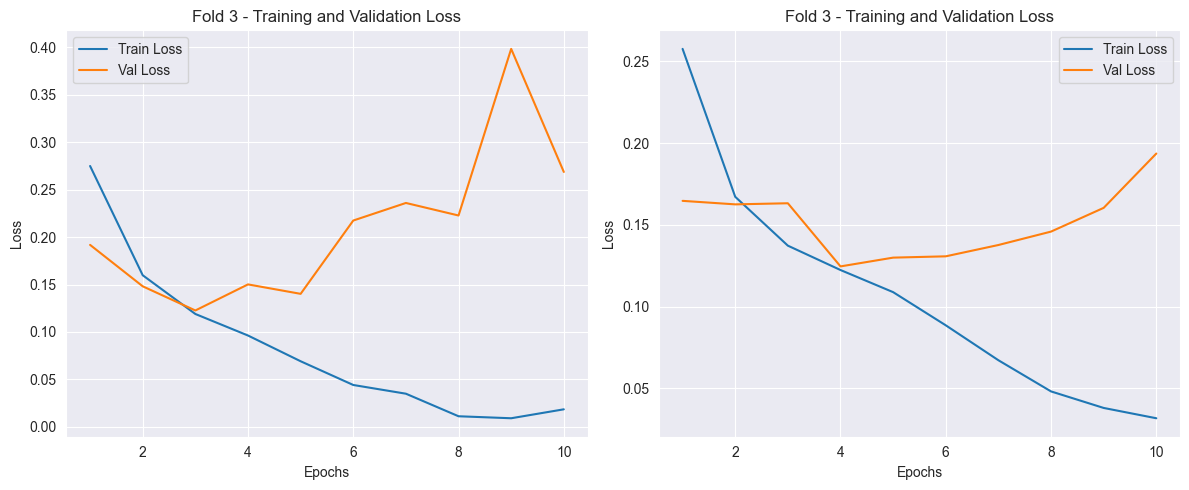

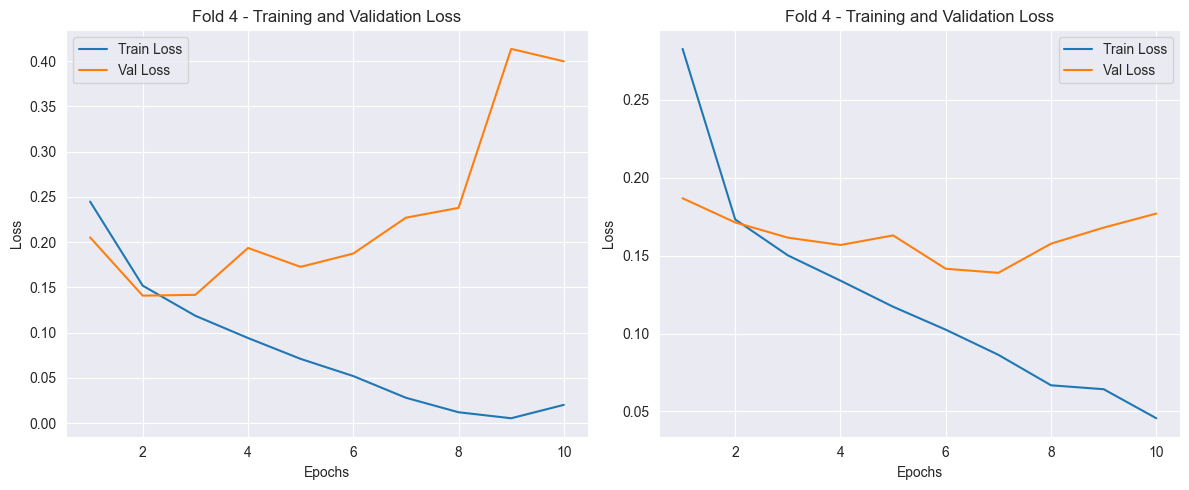

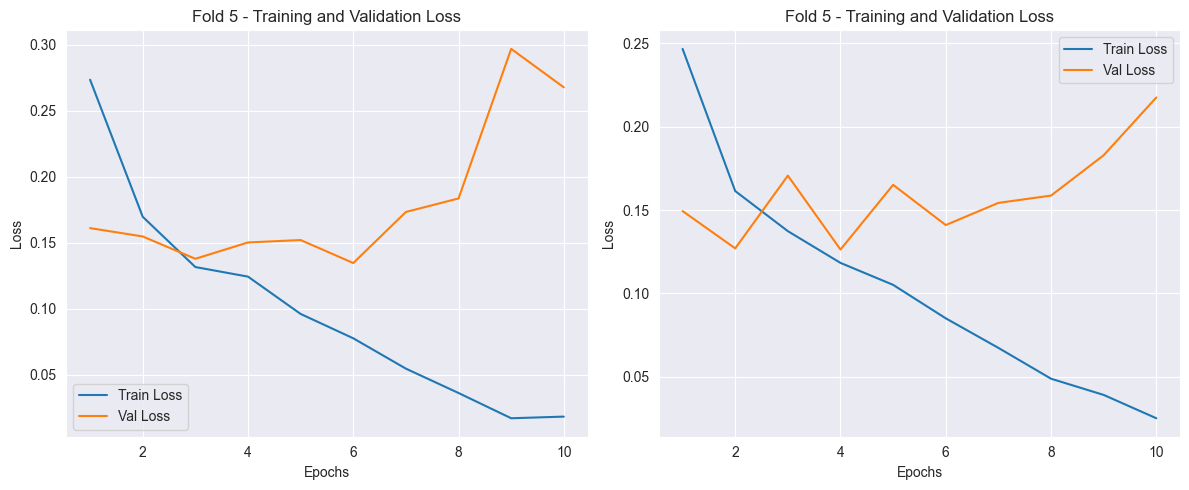

In [178]:
import pickle
import matplotlib.pyplot as plt

all_fold_results = []

file_names = ['KIundBigData_loss_curve.pkl', 'KIundBigData_loss_curve2.pkl']

for file_name in file_names:
    with open(file_name, 'rb') as f:
        fold_results = pickle.load(f)
        all_fold_results.append(fold_results)

max_epochs = max(len(fold_results[0][0]) for fold_results in all_fold_results)

for i, fold_results in enumerate(zip(*all_fold_results), start=1):
    plt.figure(figsize=(12, 5))

    for j, (train_losses, val_losses) in enumerate(fold_results, start=1):
        epochs = range(1, len(train_losses) + 1)
        
        plt.subplot(1, len(file_names), j)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.title(f'Fold {i} - Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

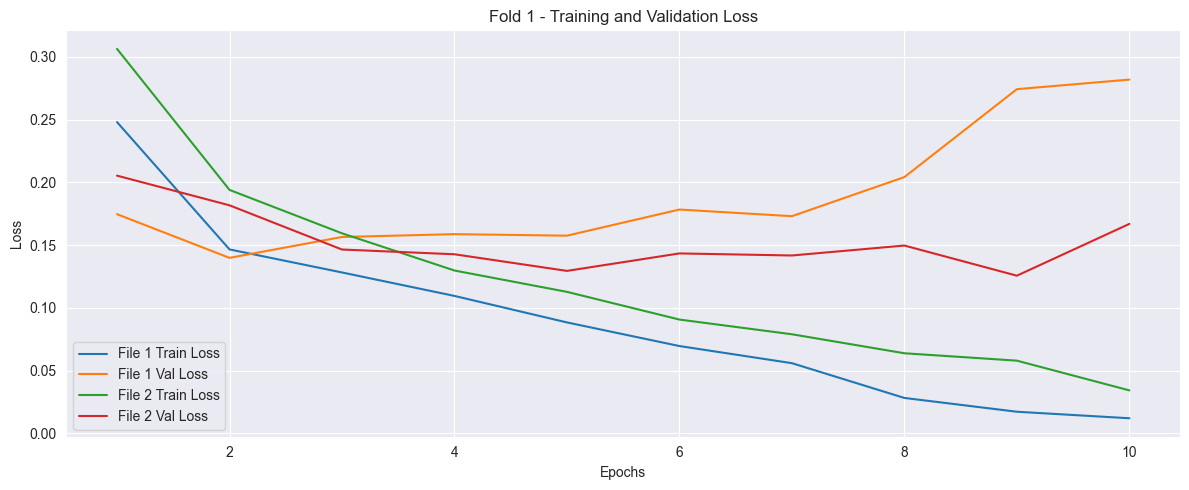

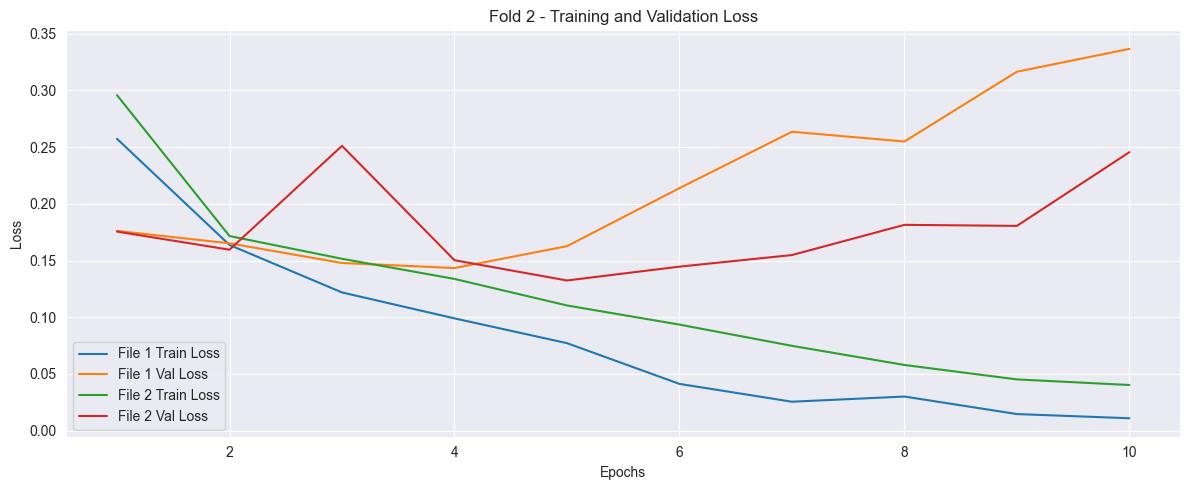

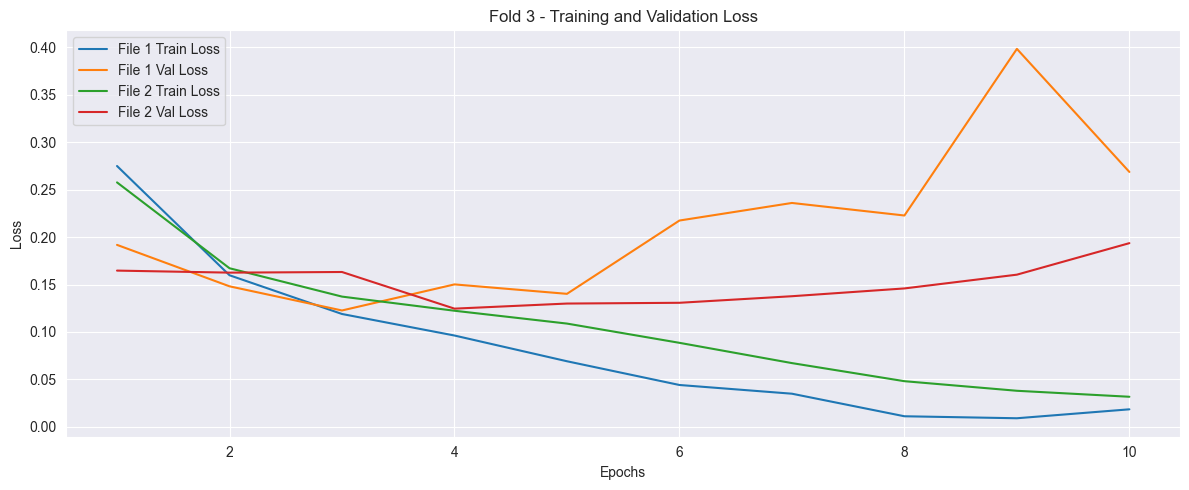

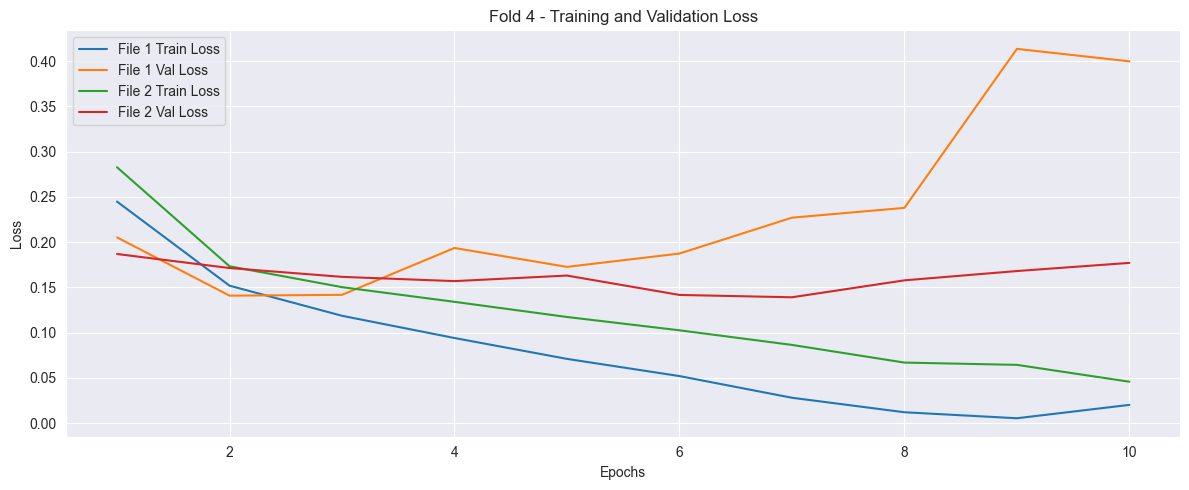

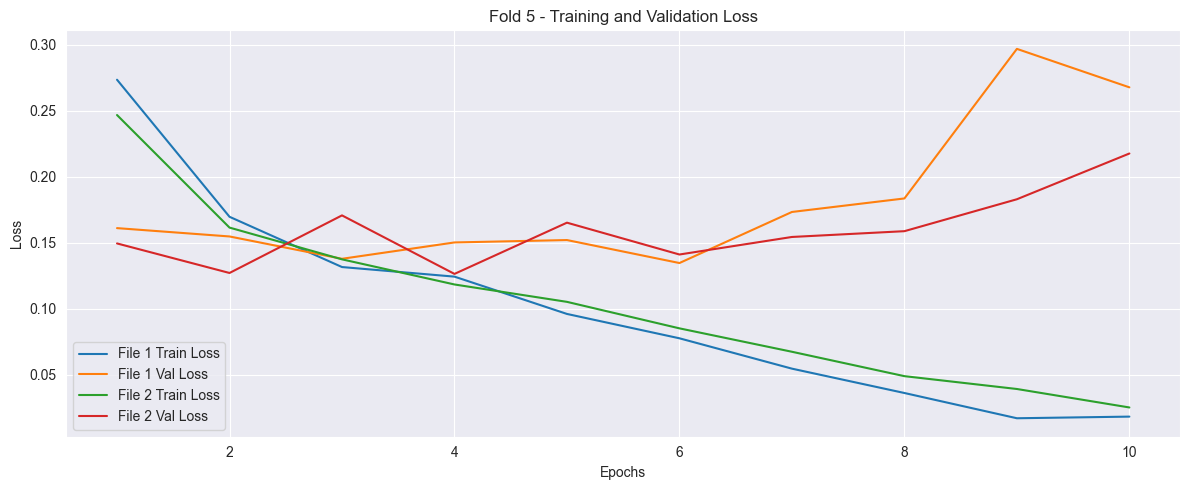

In [193]:
import pickle
import matplotlib.pyplot as plt

all_fold_results = []

file_names = ['KIundBigData_loss_curve.pkl', 'KIundBigData_loss_curve2.pkl']

for file_name in file_names:
    with open(file_name, 'rb') as f:
        fold_results = pickle.load(f)
        all_fold_results.append(fold_results)

max_epochs = max(len(fold_results[0][0]) for fold_results in all_fold_results)

for i, fold_results in enumerate(zip(*all_fold_results), start=1):
    plt.figure(figsize=(12, 5))

    for j, (train_losses, val_losses) in enumerate(fold_results):
        epochs = range(1, len(train_losses) + 1)

        plt.plot(epochs, train_losses, label=f'File {j+1} Train Loss')
        plt.plot(epochs, val_losses, label=f'File {j+1} Val Loss')

    plt.title(f'Fold {i} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 5.3. Evaluieren das kFold-Verfahren

In [186]:
avg_train_losses = []
avg_val_losses = []

for fold_result in fold_results:
    train_losses, val_losses = fold_result

    # durchschnittlichen Verlustfür jeden Fold berechnen
    avg_train_losses.append(np.mean(train_losses))
    avg_val_losses.append(np.mean(val_losses))

# Gesamtdurchschnitt und Standardabweichung für alle Folds berechnen
overall_avg_train_loss = np.mean(avg_train_losses)
overall_std_train_loss = np.std(avg_train_losses)

overall_avg_val_loss = np.mean(avg_val_losses)
overall_std_val_loss = np.std(avg_val_losses)

# Ergebnisse ausdrucken
print("Training Loss: Average = {:.4f}, Std Dev = {:.4f}".format(overall_avg_train_loss, overall_std_train_loss))
print("Validation Loss: Average = {:.4f}, Std Dev = {:.4f}".format(overall_avg_val_loss, overall_std_val_loss))

# Vor Verbesserung
# Training Loss: Average = 0.0875, Std Dev = 0.0070
# Validation Loss: Average = 0.2061, Std Dev = 0.0185

# Nach Verbesserungsversuch
# Training Loss: Average = 0.1016, Std Dev = 0.0018
# Validation Loss: Average = 0.1702, Std Dev = 0.0109

Training Loss: Average = 0.1016, Std Dev = 0.0018
Validation Loss: Average = 0.1702, Std Dev = 0.0109


### 5.4. Metriken berechnen

In [187]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Durchschnittliche Metriken berechnen
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
avg_precision = sum(fold_precisions) / len(fold_precisions)
avg_recall = sum(fold_recalls) / len(fold_recalls)
avg_f1 = sum(fold_f1s) / len(fold_f1s)
avg_roc_auc = sum(fold_roc_aucs) / len(fold_recalls)

print("Average Accuracy:", avg_accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)

# Vor Verbesserung
# Average Accuracy: 0.9431666666666667
# Average Precision: 0.7655466842724887
# Average Recall: 0.7562017226245337
# Average F1 Score: 0.7590995183401378
# Average ROC AUC: inf

# Nach Verbesserung
# Average Accuracy: 0.9505119047619048
# Average Precision: 0.7637870524940195
# Average Recall: 0.7630061443932413
# Average F1 Score: 0.7615674575074617
# Average ROC AUC: inf

Average Accuracy: 0.9505119047619048
Average Precision: 0.7637870524940195
Average Recall: 0.7630061443932413
Average F1 Score: 0.7615674575074617
Average ROC AUC: inf


 ## 6. Verbesserungsansätze

## 6.1. Methoden gegen Overfitting: L2 Regularization und Dropout
Die L2-Regularisierung reduziert die Modellkomplexität, indem sie der Verlustfunktion einen Term hinzufügt, der proportional zum Quadrat der Gewichtung ist. Dieser zusätzliche Term bestraft große Werte der Modellgewichte und begünstigt dadurch kleinere, stärker verteilte Gewichtungswerte, wodurch die Abhängigkeit des Modells von einem einzelnen Datenpunkt verringert wird.

Dropout ist eine Regularisierungstechnik, die während des Trainings zufällig einen Teil der Aktivierungseinheiten im Netzwerk „löscht“ (d. h. vorübergehend entfernt). Dies bedeutet, dass bei jeder Iteration ein kleiner Teil der Netzwerkeinheiten nicht an der Vorwärts- und Rückwärtsausbreitung teilnimmt. Dadurch wird verhindert, dass das Netzwerk übermäßig von bestimmten Funktionen abhängig ist, wodurch seine Generalisierungsfähigkeit verbessert wird.

In [173]:
# Dropout layer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNNDropout(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SimpleCNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout Layer hinzufuegen
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout verwenden
        x = self.fc2(x)
        return x

In [175]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from IPython.display import clear_output

loss_file_path = 'KIundBigData_loss_curve2.pkl'
def train_model2(device, dataloaders_list, num_epochs):
    fold_results = []

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    fold_roc_aucs = []

    for fold, (train_loader, val_loader) in enumerate(dataloaders_list, 1):
        print(f"Fold {fold}/{len(dataloaders_list)}")

        # Reset model and optimizer in each fold
        model = SimpleCNNDropout(num_classes=2)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 Regularization
        criterion = nn.CrossEntropyLoss()

        dataloaders = {'train': train_loader, 'val': val_loader}

        fold_train_losses, fold_val_losses = [], []

        # Training and validation loop
        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        if phase == 'val':
                            # Merke nur die preds und trues in letzter Epoche
                            if epoch == num_epochs - 1:
                                fold_accuracies.append(accuracy_score(labels.cpu().numpy(), preds.cpu().numpy()))
                                fold_precisions.append(
                                    precision_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0))
                                fold_recalls.append(
                                    recall_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0))
                                fold_f1s.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0))
                                try:
                                    fold_roc_aucs.append(roc_auc_score(labels.cpu().numpy(), preds.cpu().numpy()))
                                except ValueError:
                                    fold_roc_aucs.append(float('inf'))

                    running_loss += loss.item() * inputs.size(0)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)

                if phase == 'train':
                    fold_train_losses.append(epoch_loss)
                else:
                    fold_val_losses.append(epoch_loss)

            # Plotting
            clear_output(wait=True)
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(fold_train_losses, label='Train Loss')
            plt.plot(fold_val_losses, label='Val Loss')
            plt.title(f'Fold {fold} - Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        fold_results.append((fold_train_losses, fold_val_losses))

    # Save results
    with open(loss_file_path, 'wb') as f:
        pickle.dump(fold_results, f)

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s, fold_roc_aucs

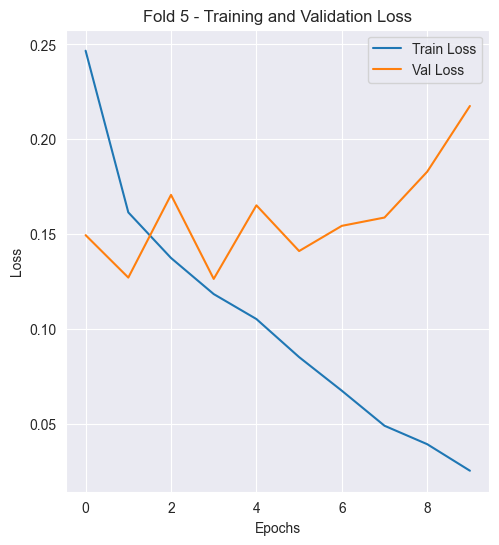

Duration：21.626205865542094 min(s)


In [176]:
import time
 
start_time = time.time()
fold_accuracies, fold_precisions, fold_recalls, fold_f1s, fold_roc_aucs = train_model2(device, dataloaders_list, num_epochs=10)
end_time = time.time()
print(f"Duration：{(end_time - start_time) / 60} min(s)")

## 6.2. train-val-test statt k-fold
Tatsächlich verfügen wir über genügend Daten und müssen nicht unbedingt kFold verwenden. Allerdings muss die Verteilung dieser Daten angepasst werden.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def collect_files(category_dir):
    files = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
    return files


def split_and_move_files(files, category, train_size, val_size):
    train_files, test_files = train_test_split(files, train_size=train_size, random_state=42)
    val_files, test_files = train_test_split(test_files, train_size=val_size / (1 - train_size), random_state=42)

    for file_set, subset in zip([train_files, val_files, test_files], ['train2', 'val2', 'test2']):
        for file_path in file_set:
            new_path = os.path.join(subset, category, os.path.basename(file_path))
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
            shutil.move(file_path, new_path)


# Process NORMAL and PNEUMONIA categories
def process(root_dir, train_size, val_size):
    for category in ['NORMAL', 'PNEUMONIA']:
        category_dir = os.path.join(root_dir, category)
        files = collect_files(category_dir)
        split_and_move_files(files, category, train_size, val_size)


process('train', train_size=0.7, val_size=0.15)
process('val', train_size=0.7, val_size=0.15)
process('test', train_size=0.7, val_size=0.15)


def check_cross_overlaps(train_files, val_files, test_files):
    for category in train_files:
        train_set = set(train_files[category])
        val_set = set(val_files[category])
        test_set = set(test_files[category])

        # Check for overlaps
        train_val_overlap = train_set.intersection(val_set)
        train_test_overlap = train_set.intersection(test_set)
        val_test_overlap = val_set.intersection(test_set)

        if train_val_overlap:
            print(f"Overlap between train and val in {category}: {train_val_overlap}")
        if train_test_overlap:
            print(f"Overlap between train and test in {category}: {train_test_overlap}")
        if val_test_overlap:
            print(f"Overlap between val and test in {category}: {val_test_overlap}")


root_dir = './'
subfolders = ['NORMAL', 'PNEUMONIA']

# Collect file paths
train_files = collect_files(os.path.join(root_dir, 'train2'), subfolders)
val_files = collect_files(os.path.join(root_dir, 'val2'), subfolders)
test_files = collect_files(os.path.join(root_dir, 'test2'), subfolders)

# Check for overlaps
check_cross_overlaps(train_files, val_files, test_files)

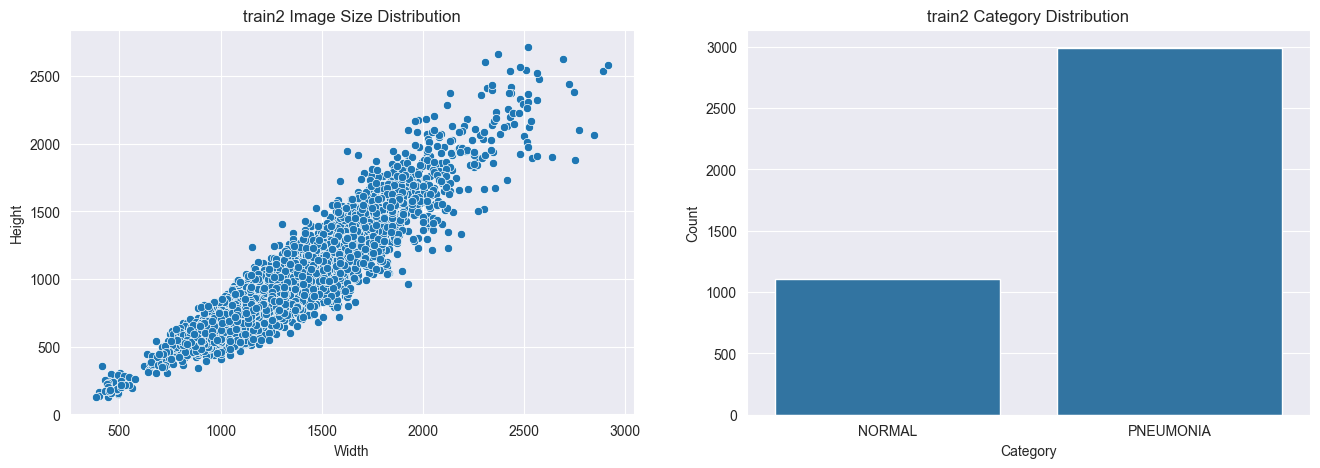

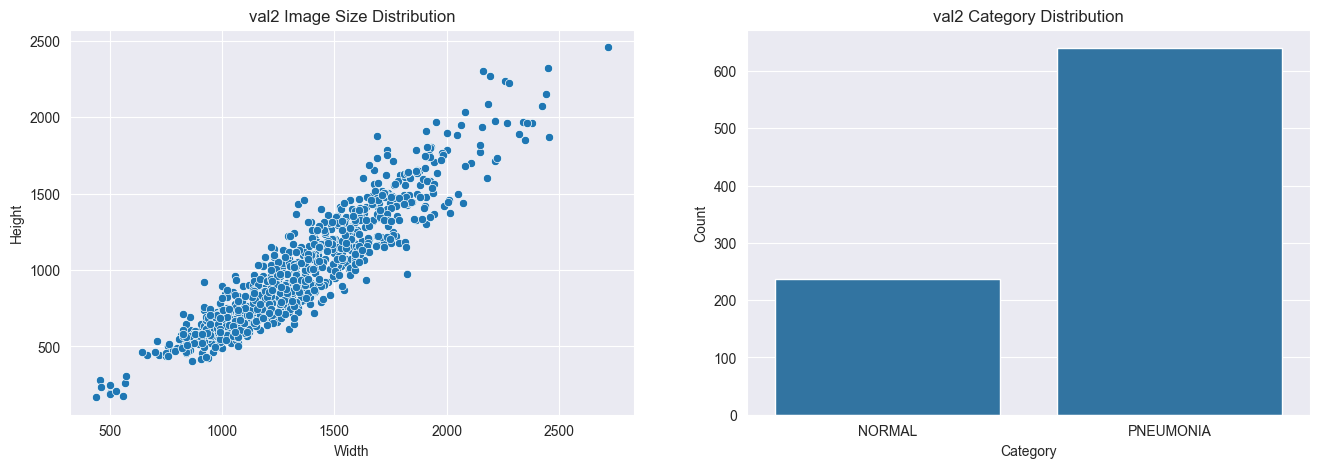

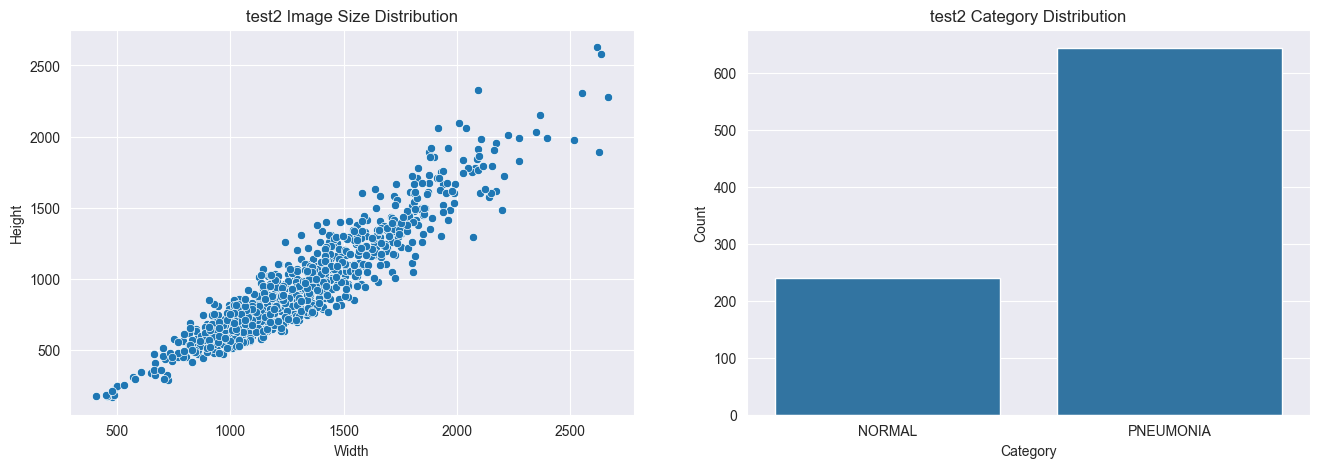

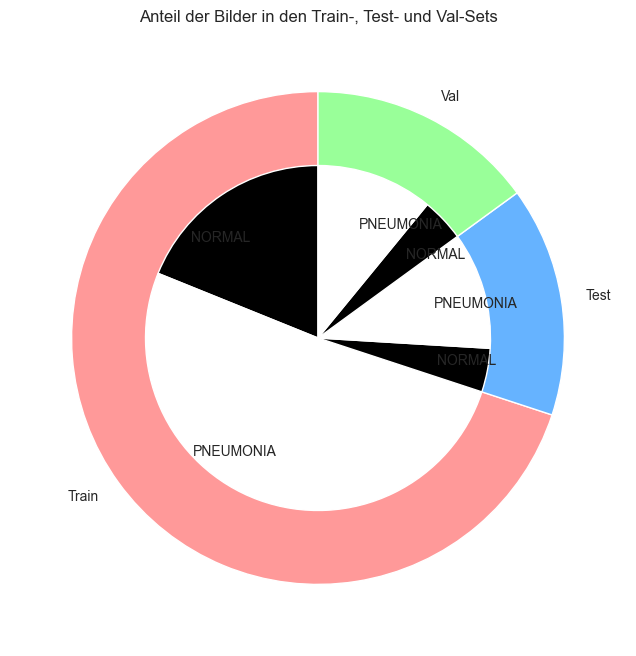

In [162]:
train, val, test = 'train2', 'val2', 'test2'

folder_paths = [train, val, test]
sizes_dic = {}
categories_dic = {}
for folder_path in folder_paths:
    sizes, categories = analyze_dataset(folder_path)
    show_size_category_distribution(folder_path, sizes, categories)
    sizes_dic[folder_path] = sizes
    categories_dic[folder_path] = categories

show_pie_chart(categories_dic)

In [188]:
loss_file_path = 'KIundBigData_loss_curve3.pkl'
def train_model3(model, dataloaders, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        for phase in ['train2', 'val2']:
            if phase == 'train2':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train2'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train2':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'train2':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            if phase == 'val2':
                clear_output(wait=True)
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 2, 1)
                plt.plot(train_losses, label='Train Loss')
                plt.plot(val_losses, label='Val Loss')
                plt.title('Training and Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

    with open(loss_file_path, 'wb') as f:
        pickle.dump((train_losses, val_losses), f)

    return model

In [189]:
num_classes = 2
model = SimpleCNN(num_classes)
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [190]:
import torchvision.datasets as datasets

# data loader
data_dir = ''
image_datasets = {x: datasets.ImageFolder(''.join([data_dir, x]), transform=transform) for x in ['train2', 'val2', 'test2']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train2', 'val2', 'test2']}

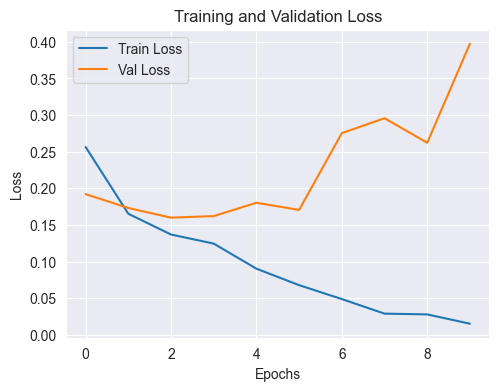

Duration：4.638366611798604 min(s)


In [191]:
import time

start_time = time.time()
model = train_model3(model, dataloaders, criterion, optimizer, num_epochs=10)
end_time = time.time()
print(f"Duration：{(end_time - start_time) / 60} min(s)")

In [192]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test2']:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Accuracy: 0.956964892412231
# Precision: 0.9809220985691574
# Recall: 0.9595645412130638
# F1 Score: 0.970125786163522
# ROC AUC: 0.9547822706065319

Accuracy: 0.956964892412231
Precision: 0.9809220985691574
Recall: 0.9595645412130638
F1 Score: 0.970125786163522
ROC AUC: 0.9547822706065319
